In [1]:
from gae.gae.GAETrainer import GAETrainer
from gae.gae.input_data import CyberDataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import cudf
import cugraph
import time
import networkx as nx
from baseline import LinkPredictor, CugraphPredictor
from sklearn.metrics import roc_auc_score, average_precision_score
sns.set_style('white')

import tensorflow as tf
tf.logging.set_verbosity('ERROR')

# Network Exploration
Load the data, and gather some preliminary descriptive stats about each network

In [2]:
def lazy_factory():
    return CyberDataset('/mnt/vgae/data')
(email_data, 
 alamos_data, 
 unsw_data, 
 gnutella_data, 
 brightkite_data,
 bitcoin_data) = (lazy_factory() for _ in range(6))

email_data.load_data("email")
alamos_data.load_data("alamos_flows")
unsw_data.load_data("UNSW")
gnutella_data.load_data("gnutella")
brightkite_data.load_data("brightkite")
bitcoin_data.load_data("bitcoin")

(<3783x3783 sparse matrix of type '<class 'numpy.int64'>'
 	with 28248 stored elements in Compressed Sparse Row format>,
 <3783x3783 sparse matrix of type '<class 'numpy.float64'>'
 	with 3783 stored elements (1 diagonals) in DIAgonal format>)

In [3]:
def degrees(G):
    return [v for _, v in G.degree()]

In [4]:
G_email = nx.from_scipy_sparse_matrix(email_data.adj)
G_alamos = nx.from_scipy_sparse_matrix(alamos_data.adj)
G_unsw = nx.from_scipy_sparse_matrix(unsw_data.adj)
G_gnutella = nx.from_scipy_sparse_matrix(gnutella_data.adj)
G_bitcoin = nx.from_scipy_sparse_matrix(bitcoin_data.adj)
for name, g in zip(('email', 'alamos', 'unsw', 'gnutella', 'bitcoin'),
                   (G_email, G_alamos, G_unsw, G_gnutella, G_bitcoin)):
    print(f"""
    ***{name}***
    n_nodes: {len(g.nodes())}
    SCCs: {nx.number_connected_components(g)}
    Avg degree: {np.mean(list(g.degree()))}
    Median degree: {np.median(list(g.degree()))}
    n_triangles: {sum(list(nx.cluster.triangles(g)))}
    Avg clustering coeff: {nx.cluster.average_clustering(g)}
    """)


    ***email***
    n_nodes: 986
    SCCs: 1
    Avg degree: 262.5420892494929
    Median degree: 82.0
    n_triangles: 485605
    Avg clustering coeff: 0.40705044751953817
    

    ***alamos***
    n_nodes: 5170
    SCCs: 10
    Avg degree: 1295.6022243713733
    Median degree: 36.5
    n_triangles: 13361865
    Avg clustering coeff: 0.00032629882547202725
    

    ***unsw***
    n_nodes: 46
    SCCs: 5
    Avg degree: 14.66304347826087
    Median degree: 10.0
    n_triangles: 1035
    Avg clustering coeff: 0.0
    

    ***gnutella***
    n_nodes: 6301
    SCCs: 2
    Avg degree: 1578.2974131090302
    Median degree: 50.5
    n_triangles: 19848150
    Avg clustering coeff: 0.010867921935819955
    

    ***bitcoin***
    n_nodes: 3783
    SCCs: 5
    Avg degree: 949.2335448057097
    Median degree: 63.5
    n_triangles: 7153653
    Avg clustering coeff: 0.17662903035907676
    


# Pipeline Setup

In [5]:
def run_gae(dataset):
    adj, features = dataset.adj, dataset.features
    trainer = GAETrainer(adj, features, cyber_dataset=dataset, epochs=200)
    print(f"***GAE Predictor***")
    train_roc, train_ap = trainer.train()
    t = time.time()
    test_roc, test_ap = trainer.eval()
    elapsed = time.time() - t
    print(f"Inference time: {elapsed} -- {(len(trainer.test_edges) + len(trainer.test_edges_false)) / elapsed} edges/sec")
    print(f"Train ROC: {train_roc[-1]}")
    print(f"Train AP: {train_ap[-1]}")
    return trainer

In [6]:
# Baseline link predictor using adamic adar index
def run_baseline(trainer, use_cugraph=False):
    t = time.time()
    if use_cugraph:
        G_train = cugraph.Graph()
        data = trainer.cyber_dataset.edge_list
        G_train.add_edge_list(cudf.Series(data[:, 0]).astype('int32'),
                              cudf.Series(data[:, 1].astype('int32')))
        clf = CugraphPredictor(G_train).train(trainer.val_edges, trainer.val_edges_false)
        test_set = np.append(trainer.test_edges, trainer.test_edges_false, axis=0)
        pred = clf.predict(cudf.Series(test_set[:, 0]), cudf.Series(test_set[:, 1])).iloc[:, 2].to_array()
    else:
        G_train = nx.from_numpy_array(trainer.adj_train.toarray())
        clf = LinkPredictor(metric=nx.link_prediction.jaccard_coefficient).train(G_train, trainer.val_edges, trainer.val_edges_false)
        pred = np.append(clf.predict(trainer.test_edges), clf.predict(trainer.test_edges_false))
    elapsed = time.time() - t
    print(f"***Baseline Predictor***")
    print(f"Inference time: {elapsed} -- {(len(trainer.test_edges) + len(trainer.test_edges_false) / elapsed)} edges/sec")
    actual = np.array([trainer.adj_orig[(u, v)] for (u, v) in np.append(trainer.test_edges, trainer.test_edges_false, axis=0)])
    

    print(f"Baseline Test ROC: {roc_auc_score(actual, pred)}")
    print(f"Baseline Test AP: {average_precision_score(pred, actual)}")

# Email Data
A mid-sized user interaction dataset with a regular degree distribution

In [7]:
%%time
trainer = run_gae(email_data)

***GAE Predictor***
Optimization Finished!
Test ROC score: 0.909389834819303
Test AP score: 0.9201509180242752
Inference time: 0.11947989463806152 -- 26883.184068165265 edges/sec
Train ROC: 0.9167691517953379
Train AP: 0.9213620928556177
CPU times: user 11min 58s, sys: 1min 11s, total: 13min 10s
Wall time: 23.7 s


In [8]:
%%time
run_baseline(trainer)

***Baseline Predictor***
Inference time: 1.5895578861236572 -- 2616.343828318476 edges/sec
Baseline Test ROC: 0.8424657534246576
Baseline Test AP: 0.8068775978309639
CPU times: user 4.42 s, sys: 228 ms, total: 4.64 s
Wall time: 1.66 s


Below is an example of using cugraph's jaccard coefficient implementation as a baseline link predictor, rather than networkx. We fail to see a speedup here because this dataset is far too small to make up for cugraph's overhead

In [9]:
%%time
run_baseline(trainer, use_cugraph=True)

***Baseline Predictor***
Inference time: 58.50176954269409 -- 1633.4521610637428 edges/sec
Baseline Test ROC: 0.5105853051058531
Baseline Test AP: 0.29564762505411574
CPU times: user 55.4 s, sys: 1.79 s, total: 57.2 s
Wall time: 58.6 s


count    986.000000
mean      32.584178
std       37.044294
min        1.000000
25%        6.250000
50%       22.000000
75%       44.750000
max      345.000000
dtype: float64


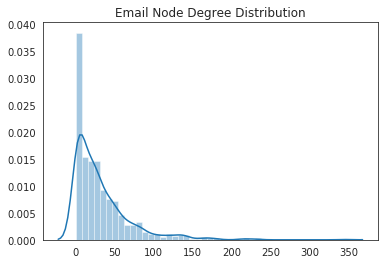

In [10]:
sns.distplot(degrees(G_email))
plt.title("Email Node Degree Distribution")
print(pd.Series(degrees(G_email)).describe())

# Alamos Flow Data
A larger, heterogeneous dataset with a more prominent set of supernodes

In [11]:
%%time
trainer = run_gae(alamos_data)

***GAE Predictor***
Optimization Finished!
Test ROC score: 0.8704923169232133
Test AP score: 0.9301955596812981
Inference time: 0.3270859718322754 -- 10596.602417964017 edges/sec
Train ROC: 0.8786695486135188
Train AP: 0.9339972278246063
CPU times: user 43min 17s, sys: 16min 2s, total: 59min 20s
Wall time: 2min 4s


In [12]:
%%time
run_baseline(trainer)

***Baseline Predictor***
Inference time: 7.016719818115234 -- 1979.9815020297478 edges/sec
Baseline Test ROC: 0.4708597807270629
Baseline Test AP: 0.029140219272937102
CPU times: user 7.02 s, sys: 72 ms, total: 7.1 s
Wall time: 7.1 s


In [13]:
%%time
run_baseline(trainer, use_cugraph=False)

***Baseline Predictor***
Inference time: 6.955996990203857 -- 1982.1375431071328 edges/sec
Baseline Test ROC: 0.4708597807270629
Baseline Test AP: 0.029140219272937102
CPU times: user 6.98 s, sys: 80 ms, total: 7.06 s
Wall time: 7.07 s


count    5170.000000
mean        6.704449
std        52.155337
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      2014.000000
dtype: float64

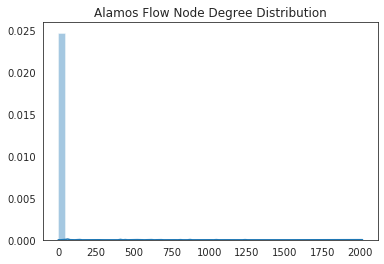

In [14]:
sns.distplot(degrees(G_alamos))
plt.title("Alamos Flow Node Degree Distribution")
pd.Series(degrees(G_alamos)).describe()

# UNSW Data
A very small, distributed dataset with an extremely irregular, multimodal degree distribution

In [15]:
%%time
trainer = run_gae(unsw_data)

***GAE Predictor***
Optimization Finished!
Test ROC score: 0.76
Test AP score: 0.6843979168979168
Inference time: 0.0038175582885742188 -- 7858.426180364727 edges/sec
Train ROC: 0.8367346938775511
Train AP: 0.8715213358070499
CPU times: user 2.18 s, sys: 572 ms, total: 2.75 s
Wall time: 1.56 s


In [16]:
%%time
run_baseline(trainer)

***Baseline Predictor***
Inference time: 0.08691620826721191 -- 187.5800089424583 edges/sec
Baseline Test ROC: 0.4
Baseline Test AP: 0.1
CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 90.5 ms


count    46.000000
mean      6.826087
std       3.808204
min       1.000000
25%       4.000000
50%      10.000000
75%      10.000000
max      12.000000
dtype: float64

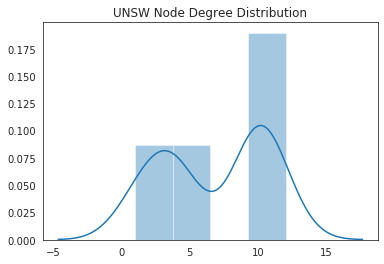

In [17]:
sns.distplot(degrees(G_unsw))
plt.title("UNSW Node Degree Distribution")
pd.Series(degrees(G_unsw)).describe()

# Gnutella Data
A large user interaction network with only two connected components whose degree distribution is normally skewed, but multimodal

In [18]:
%%time
trainer = run_gae(gnutella_data)

***GAE Predictor***
Optimization Finished!
Test ROC score: 0.6120356871891031
Test AP score: 0.6902684147399992
Inference time: 0.43488311767578125 -- 9551.991859791933 edges/sec
Train ROC: 0.616275648664803
Train AP: 0.6958917413383547
CPU times: user 53min 3s, sys: 25min 51s, total: 1h 18min 54s
Wall time: 2min 57s


In [19]:
%%time
run_baseline(trainer)

***Baseline Predictor***
Inference time: 1.2329809665679932 -- 3761.5353304855444 edges/sec
Baseline Test ROC: 0.5599422243620605
Baseline Test AP: 0.12722476994515156
CPU times: user 1.18 s, sys: 140 ms, total: 1.32 s
Wall time: 1.32 s


count    6301.000000
mean        6.594826
std         8.541018
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max        97.000000
dtype: float64

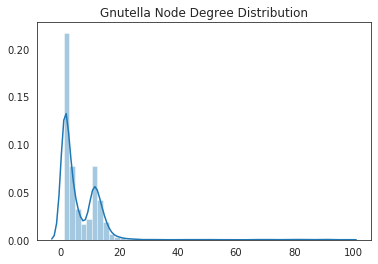

In [20]:
G_gnutella = nx.from_scipy_sparse_matrix(gnutella_data.adj)
sns.distplot(degrees(G_gnutella))
import matplotlib.pyplot as plt
plt.title("Gnutella Node Degree Distribution")
pd.Series(degrees(G_gnutella)).describe()

# Bitcoin Data
A user-user trust network with a similar size to the gnutella network and five connected components

In [21]:
%%time
trainer = run_gae(bitcoin_data)

***GAE Predictor***
Optimization Finished!
Test ROC score: 0.8224536349701868
Test AP score: 0.8808616788391885
Inference time: 0.24956583976745605 -- 11315.65122306557 edges/sec
Train ROC: 0.8100478296110233
Train AP: 0.8735700922532478
CPU times: user 32min 36s, sys: 6min 6s, total: 38min 43s
Wall time: 1min 12s


In [22]:
%%time
run_baseline(trainer)

***Baseline Predictor***
Inference time: 1.2693641185760498 -- 2524.3679796337374 edges/sec
Baseline Test ROC: 0.798158640226629
Baseline Test AP: 0.6324007104458969
CPU times: user 1.3 s, sys: 28 ms, total: 1.33 s
Wall time: 1.33 s


count    3783.000000
mean        7.467090
std        20.055671
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       511.000000
dtype: float64

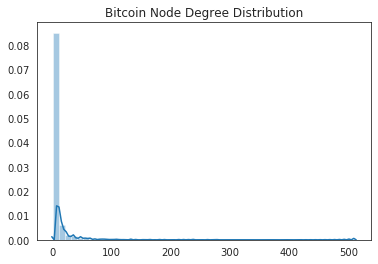

In [23]:
sns.distplot(degrees(G_bitcoin))
plt.title("Bitcoin Node Degree Distribution")
pd.Series(degrees(G_bitcoin)).describe()